# AiiDA Tutorial

In [102]:
import os, pathlib, shutil

## Direct Run


In [103]:
!mkdir -p direct_run/out
!rm -rf direct_run/out/*
!cd direct_run && mpirun -np 2 pw.x -in aiida.in > out/aiida.out

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


In [61]:
!tail -n 5 direct_run/out/aiida.out

   This run was terminated on:  21:58:59  20Sep2022            

=------------------------------------------------------------------------------=
   JOB DONE.
=------------------------------------------------------------------------------=


In [104]:
!ls
# import qeschema

# pw_document = qeschema.PwDocument()
# data = pw_document.read("direct_run/out/aiida.xml")
# data = pw_document.to_dict()["qes:espresso"]
# print(data["parallel_info"])
# print(data["output"]["convergence_info"])


_aiida_config  _build         direct_run     sssp_pseudos
_aiida_workdir conf.py        intro.ipynb


- What if we want to run more than one computation?
- What if we want to chain this computation to others?
- What if things go wrong?
- How do we work with a HPC cluster?


## Transitioning to AiiDA


In [12]:
os.environ["AIIDA_PATH"] = os.path.abspath("_aiida_config")

%load_ext aiida

In [13]:
from aiida import engine, load_profile, orm, plugins
from aiida.storage.sqlite_temp import SqliteTempBackend
from aiida.tools.visualization import Graph

profile = load_profile(
    SqliteTempBackend.create_profile(
        "temp_profile",
        options={"runner.poll.interval": 1},
        debug=False,
    ),
)
profile

Profile<uuid='4f1051f9b05b4a5c9210cec868c76d8e' name='temp_profile'>

In [63]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.1
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


In [14]:
_, computer = orm.Computer.collection.get_or_create(
    label="local_direct",
    description="local computer with direct scheduler",
    hostname="localhost",
    workdir=os.path.abspath("_aiida_workdir"),
    transport_type="core.local",
    scheduler_type="core.direct",
)
computer.store()
computer.set_minimum_job_poll_interval(0.0)
computer.set_default_mpiprocs_per_machine(2)
computer.configure()
computer

<Computer: local_direct (localhost), pk: 1>

In [15]:
try:
    code = orm.load_code("pw.x@local_direct")
except:
    code = orm.Code(
        input_plugin_name="quantumespresso.pw",
        remote_computer_exec=[computer, shutil.which("pw.x")],
    )
    code.label = "pw.x"
    code.store()
code

<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 082517db-c2ae-42d4-9a96-6b95dff630fe>

In [42]:
builder = code.get_builder()

import qe_tools

pw_input = qe_tools.parsers.PwInputFile(open("direct_run/aiida.in").read())

builder.structure = orm.StructureData(cell=pw_input.structure["cell"])
for p, s in zip(pw_input.structure["positions"], pw_input.structure["atom_names"]):
    builder.structure.append_atom(position=p, symbols=s)

parameters = pw_input.namelists
for disallowed in ["pseudo_dir", "outdir", "prefix"]:
    parameters["CONTROL"].pop(disallowed, None)
for disallowed in ["nat", "ntyp"]:
    parameters["SYSTEM"].pop(disallowed, None)
builder.parameters = orm.Dict(dict=parameters)

builder.kpoints = orm.KpointsData()
builder.kpoints.set_cell_from_structure(builder.structure)
builder.kpoints.set_kpoints_mesh(
    pw_input.k_points["points"],
    offset=pw_input.k_points["offset"],
)

builder.pseudos = {
    "Si": orm.UpfData.get_or_create(
        os.path.abspath("direct_run/pseudo/Si.pbe-n-rrkjus_psl.1.0.0.UPF")
    )[0]
}

builder

Process class: PwCalculation
Inputs:
code: ''
kpoints: 'Kpoints mesh: 5x5x5 (+0.0,0.0,0.0)'
metadata:
  options:
    stash: {}
parameters:
  CONTROL:
    calculation: relax
    etot_conv_thr: 0.0002
    forc_conv_thr: 0.001
    max_seconds: 41040.0
    restart_mode: from_scratch
    tprnfor: true
    tstress: true
    verbosity: high
  ELECTRONS:
    conv_thr: 8.0e-10
    electron_maxstep: 80
    mixing_beta: 0.4
  SYSTEM:
    degauss: 0.01
    ecutrho: 240.0
    ecutwfc: 30.0
    ibrav: 0
    nosym: false
    occupations: smearing
    smearing: cold
pseudos:
  Si: ''
structure: Si


In [ ]:
output = engine.run_get_node(builder)
output

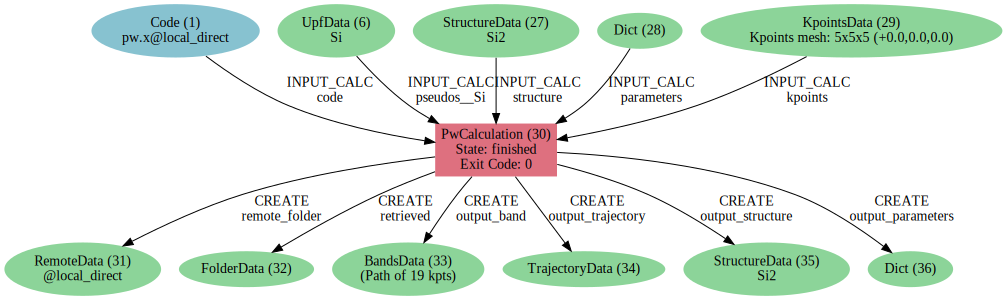

In [43]:
graph = Graph()
graph.add_incoming(output.node, annotate_links="both")
graph.add_outgoing(output.node, annotate_links="both")
graph.graphviz

In [65]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 1
  Nodes:
    count: 36
  Groups:
    count: 0
  Comments:
    count: 0
  Logs:
    count: 6
  Links:
    count: 40



## Automating Data Inputs

### AiiDA Pseudopotential Families


```console
$ aiida-pseudo install sssp -x PBE -p efficiency -v 1.1
```

In [85]:
import json
from aiida_pseudo.cli.install import download_sssp
from aiida_pseudo.cli.utils import create_family_from_archive
from aiida_pseudo.groups.family import SsspConfiguration, SsspFamily

config = SsspConfiguration("1.1", "PBE", "efficiency")
label = SsspFamily.format_configuration_label(config)

try:
    family = orm.Group.collection.get(label=label)
except:
    pseudos = pathlib.Path("sssp_pseudos")
    pseudos.mkdir(exist_ok=True)

    download_sssp(config, pseudos / "sssp.tar.gz", pseudos / "sssp.json")

    family = create_family_from_archive(
        SsspFamily,
        label,
        pseudos / "sssp.tar.gz",
    )
    family.set_cutoffs(
        {
            k: {i: v[i] for i in ["cutoff_wfc", "cutoff_rho"]}
            for k, v in json.loads((pseudos / "sssp.json").read_text()).items()
        },
        "normal",
        unit="Ry",
    )

str(family)

'SsspFamily<SSSP/1.1/PBE/efficiency>'

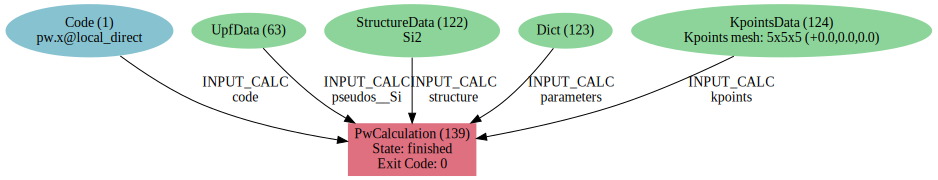

In [90]:
builder.pseudos = family.get_pseudos(structure=builder.structure)
output = engine.run_get_node(builder)
graph = Graph()
graph.add_incoming(output.node, annotate_links="both")
graph.graphviz

### Structures from the COD


TODO pymatgen / ase integration

In [101]:
from aiida.tools.dbimporters.plugins.cod import CodEntry

entry = CodEntry("http://www.crystallography.net/cod/1526655.cif")
structure = entry.get_aiida_structure()
structure.get_pymatgen()

Structure Summary
Lattice
    abc : 5.381 5.381 5.381
 angles : 90.0 90.0 90.0
 volume : 155.80772134100002
      A : 5.381 0.0 3.294912213105954e-16
      B : -3.294912213105954e-16 5.381 3.294912213105954e-16
      C : 0.0 0.0 5.381
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (1.3453, 1.3453, 1.3453) [0.2500, 0.2500, 0.2500]
PeriodicSite: Si (-0.0000, 2.6905, 2.6905) [0.0000, 0.5000, 0.5000]
PeriodicSite: Si (4.0358, 1.3453, 4.0357) [0.7500, 0.2500, 0.7500]
PeriodicSite: Si (2.6905, 0.0000, 2.6905) [0.5000, 0.0000, 0.5000]
PeriodicSite: Si (1.3452, 4.0358, 4.0357) [0.2500, 0.7500, 0.7500]
PeriodicSite: Si (2.6905, 2.6905, 0.0000) [0.5000, 0.5000, 0.0000]
PeriodicSite: Si (4.0358, 4.0358, 1.3453) [0.7500, 0.7500, 0.2500]

## Workflows